# Deep Learning with PyTorch : Build a Generative Adversarial Network

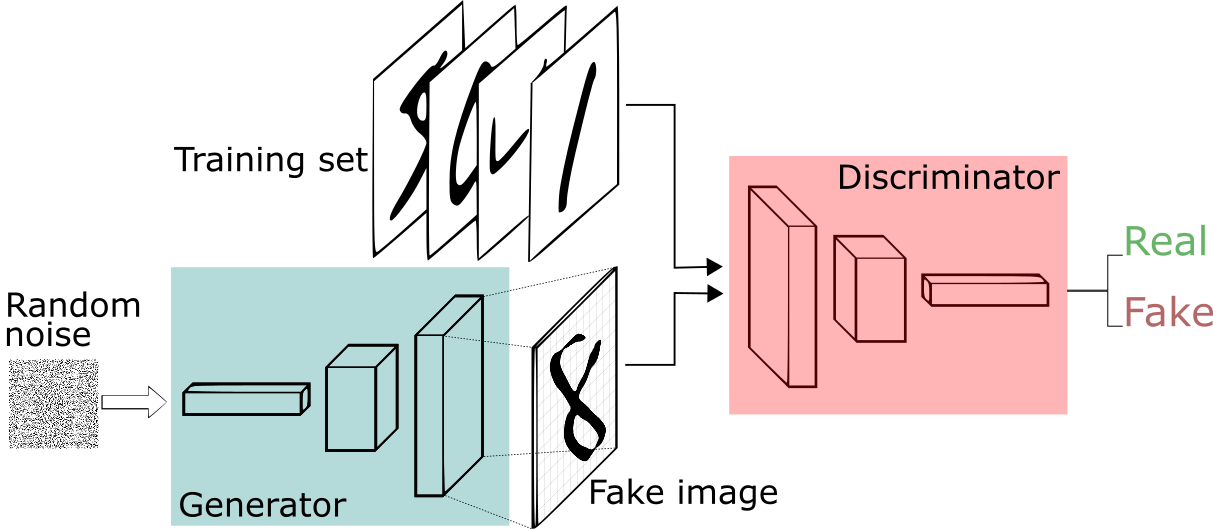

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda'  # image = image.to(devive)

batch_size = 128   # trainloader, training loop

noise_dim = 64   # generator model

# Optimizer Parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

# Training variables
epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor()
])

In [ ]:
trainset = datasets.MNIST('MNIST/', train = True, download = True, transform = train_augs)

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.4MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.00MB/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.22MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



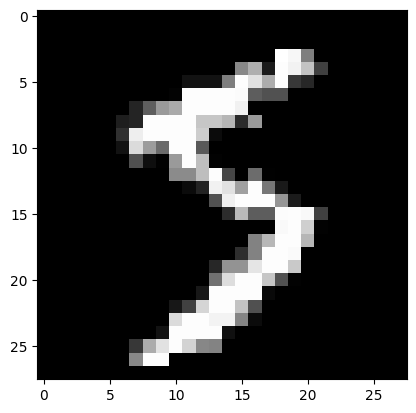

In [ ]:
image, label = trainset[0]

plt.imshow(image.squeeze(), cmap = 'gray')

In [ ]:
print('Total images present in trainset are:', len(trainset))

Total images present in trainset are: 60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print("Total no of batches in trainloader:", len(trainloader))

Total no of batches in trainloader: 469


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print('Shape of images:', images.shape)

Shape of images: torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

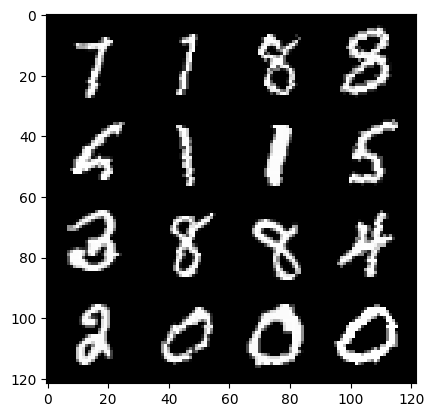

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = get_disc_block(1, 16, 3, 2)
        self.block2 = get_disc_block(16, 32, 5, 2)
        self.block3 = get_disc_block(32, 64, 5, 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):
        x = self.block1(images)
        x = self.block2(x)
        x = self.block3(x)

        x = self.flatten(x)
        x = self.linear(x)

        return x

In [ ]:
D = Discriminator().to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.Tanh())

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU())

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim

        self.block1 = get_gen_block(noise_dim, 256, 3, 2)
        self.block2 = get_gen_block(256, 128, 4, 1)
        self.block3 = get_gen_block(128, 64, 3, 2)

        self.block4 = get_gen_block(64, 1, 4, 2, final_block=True)


    def forward(self, random_noise_vector):
        x = random_noise_vector.view(-1, self.noise_dim, 1, 1)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        return x

In [ ]:
G = Generator(noise_dim).to(device)

summary(G, input_size=(noise_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
      BatchNorm2d-11            [-1, 1, 28, 28]               2
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 747,843
Trainable params: 747,843
Non-trainable params: 0
-------------------------------

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.4866458210609615 | G_loss: 0.9573686134332279


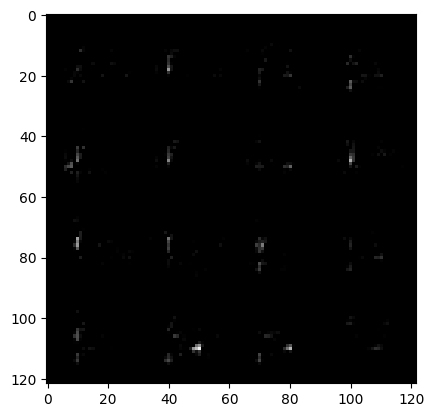

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.4389588919911049 | G_loss: 1.069794783015241


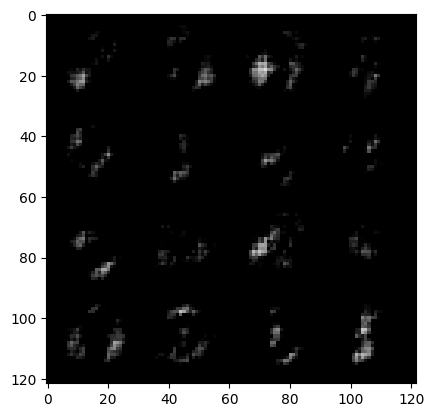

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.5314899869819185 | G_loss: 1.0331835286703699


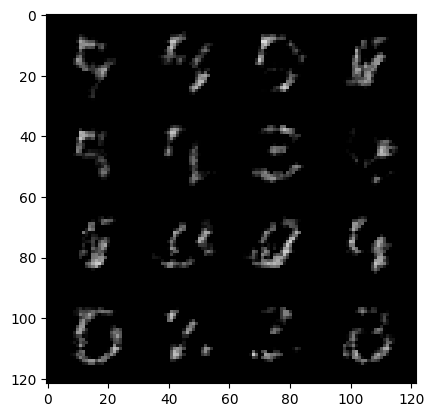

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.5272474627632068 | G_loss: 1.0001190907157052


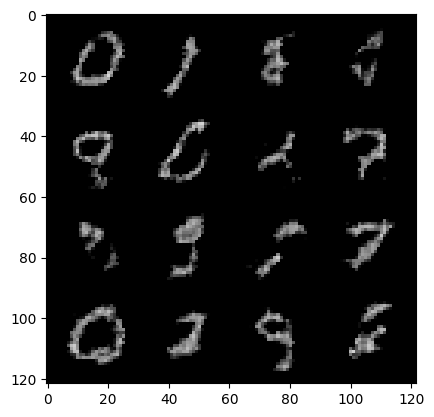

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.6726044669334315 | G_loss: 0.7388124432899296


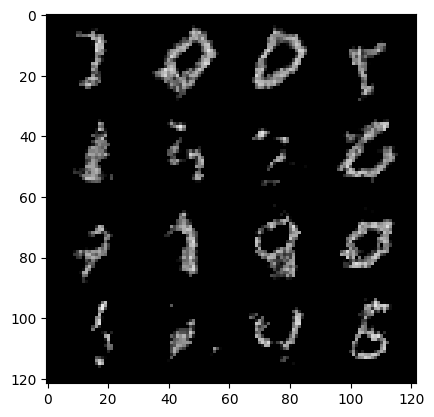

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.6821628187511013 | G_loss: 0.7184485347032039


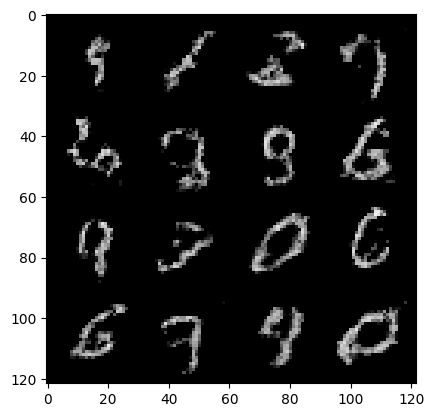

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.6779967507065486 | G_loss: 0.7259611154415968


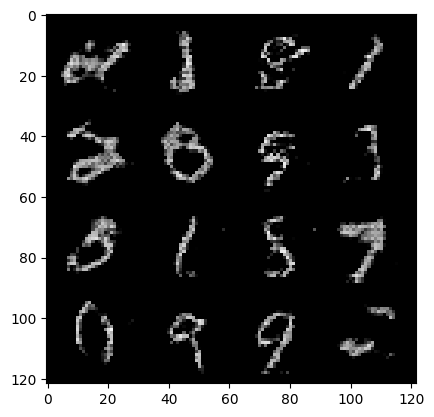

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.6750981707308592 | G_loss: 0.7351183667620108


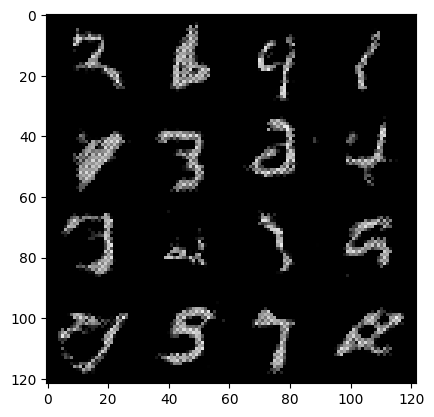

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.6759023099565811 | G_loss: 0.7307984432431934


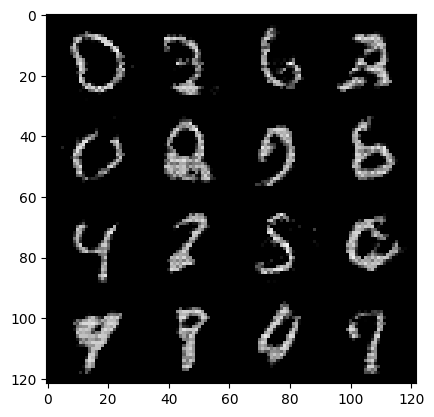

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.6774161576208021 | G_loss: 0.7293078330025744


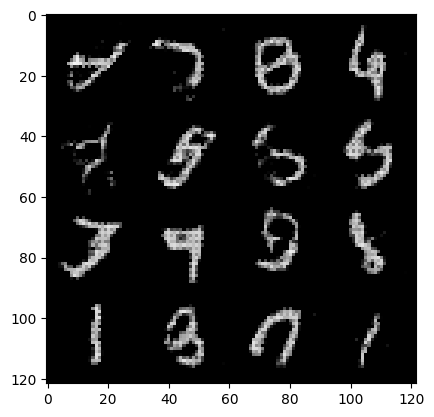

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.678309209565364 | G_loss: 0.7282339564518634


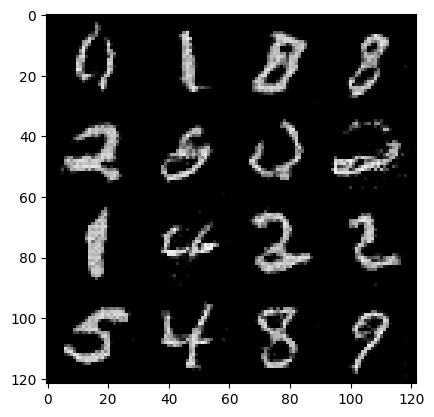

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.6782486906437986 | G_loss: 0.7285995914229452


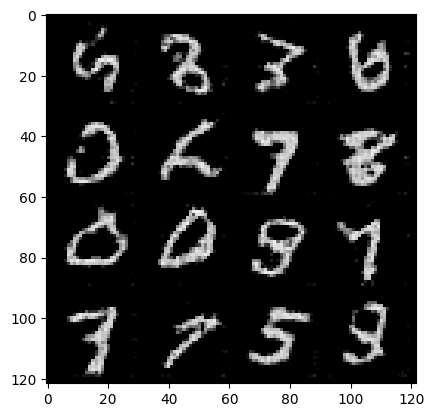

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.6768982353240951 | G_loss: 0.7362592067799842


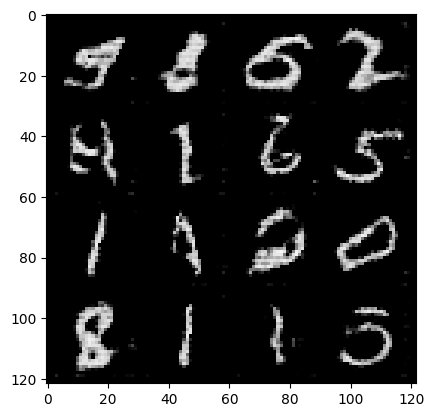

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.6785537573828626 | G_loss: 0.7344468763388042


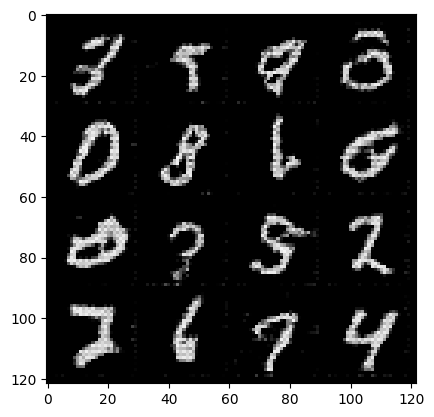

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.6809863931080425 | G_loss: 0.7269855056490216


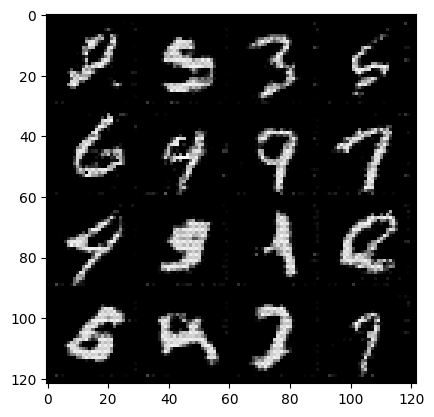

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.681982610525607 | G_loss: 0.7245207587793183


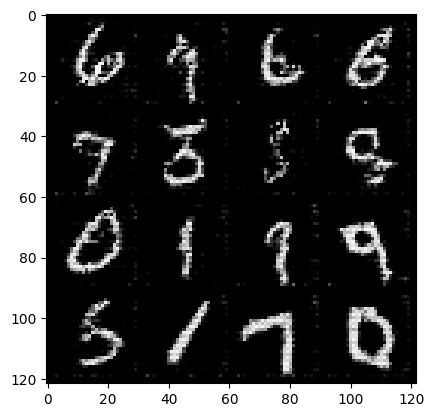

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.6835575561279427 | G_loss: 0.7246920639263795


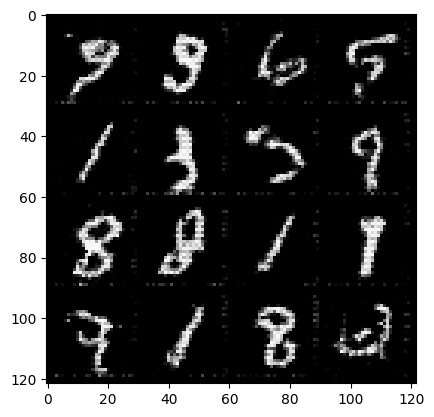

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.6839213381443959 | G_loss: 0.7226426966154753


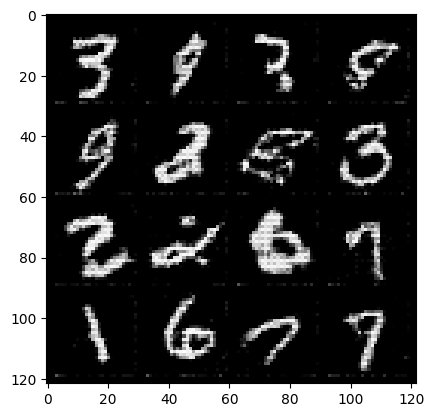

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.68528739412202 | G_loss: 0.7219889090259446


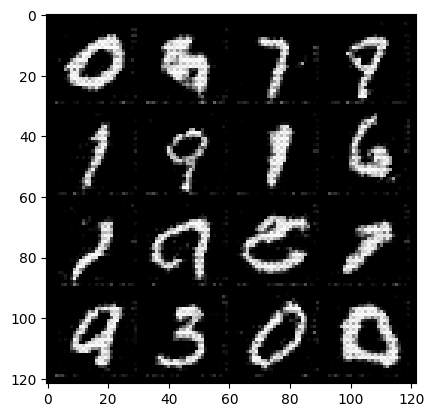

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.6865320837319787 | G_loss: 0.7188442715449628


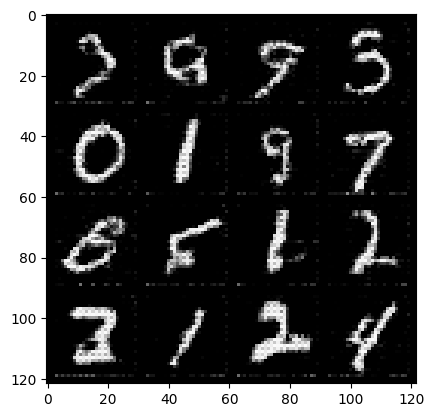

In [ ]:
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_images, _ in tqdm(trainloader):
        real_images = real_images.to(device)
        noise = torch.randn(batch_size, noise_dim, device = device)

        # Find the loss and update the weights for the discriminator network
        D_opt.zero_grad()

        fake_images = G(noise)
        disc_fake_pred = D(fake_images.detach())
        disc_fake_loss = fake_loss(disc_fake_pred)

        disc_real_pred = D(real_images)
        disc_real_loss = real_loss(disc_real_pred)

        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        total_d_loss += disc_loss.item()

        # Gradients
        disc_loss.backward()
        D_opt.step()

        # Find the loss and update the weights for the generator network
        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device = device)

        fake_images = G(noise)
        disc_fake_pred = D(fake_images)
        gen_loss = real_loss(disc_fake_pred)
        total_g_loss += gen_loss.item()

        # Gradients
        gen_loss.backward()
        G_opt.step()

    avg_disc_loss = total_d_loss / len(trainloader)
    avg_gen_loss = total_g_loss / len(trainloader)

    print('Epoch: {} | D_loss: {} | G_loss: {}'.format(i+1, avg_disc_loss, avg_gen_loss))

    show_tensor_images(fake_images)

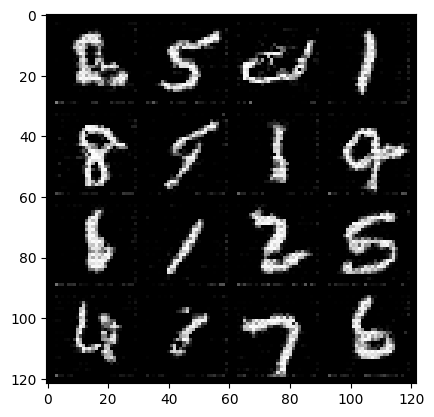

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya